In [1]:
# Basic Python and system libraries
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
import os

# Base directory of your dataset
base_dir = '/kaggle/input/brain-tumor-segmentation/Brain Tumor Segmentation Dataset'

# Image and mask root directories
image_dir = os.path.join(base_dir, 'image')
mask_dir = os.path.join(base_dir, 'mask')


In [4]:
class BrainTumorSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None, target_size=(512, 512)):
        self.image_paths = []
        self.mask_paths = []
        self.transform = transform
        self.mask_transform = mask_transform
        self.target_size = target_size

        for tumor_class in ['0', '1', '2', '3']:
            img_folder = os.path.join(image_dir, tumor_class)
            mask_folder = os.path.join(mask_dir, tumor_class)

            for img_name in os.listdir(img_folder):
                if img_name.endswith('.jpg'):
                    img_path = os.path.join(img_folder, img_name)
                    mask_name = img_name.replace('.jpg', '_m.jpg')
                    mask_path = os.path.join(mask_folder, mask_name)

                    if os.path.exists(mask_path):
                        self.image_paths.append(img_path)
                        self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB").resize(self.target_size)
        mask = Image.open(self.mask_paths[idx]).convert("L").resize(self.target_size)

        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = transforms.ToTensor()(mask)

        return image, mask


In [5]:
# Define transforms (same as before)
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
mask_transform = transforms.ToTensor()

# Load dataset with resizing included
dataset = BrainTumorSegmentationDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    transform=image_transform,
    mask_transform=mask_transform,
    target_size=(256, 256)
)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


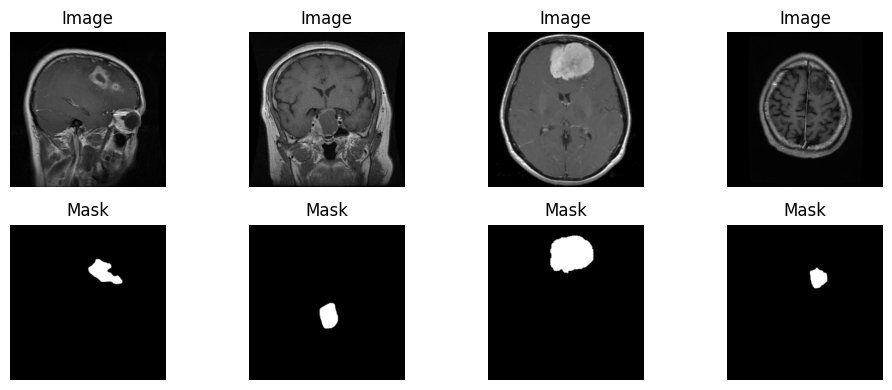

In [6]:
images, masks = next(iter(dataloader))

plt.figure(figsize=(10, 4))
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(2, 4, i+5)
    plt.imshow(masks[i][0], cmap="gray")
    plt.title("Mask")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [7]:
from torch.utils.data import random_split

# Total size
total_size = len(dataset)

# Split sizes
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Perform the split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 3389, Val: 423, Test: 425


In [8]:
class BrainTumorSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, augment=False, target_size=(256, 256)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.augment = augment
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        # Resize
        image = image.resize(self.target_size)
        mask = mask.resize(self.target_size)

        # Convert to tensor first so we can do flipping and rotation
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)

        if self.augment:
            # Random horizontal flip
            if torch.rand(1) > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)

            # Random rotation
            angle = torch.randint(-15, 15, (1,)).item()
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

        # Normalize image
        image = transforms.Normalize([0.5]*3, [0.5]*3)(image)

        return image, mask


In [9]:
# Get image/mask paths from full dataset
all_image_paths = dataset.image_paths
all_mask_paths = dataset.mask_paths

# Shuffle paths in unison
combined = list(zip(all_image_paths, all_mask_paths))
np.random.seed(42)
np.random.shuffle(combined)
image_paths, mask_paths = zip(*combined)

# Split into train/val/test
train_imgs = image_paths[:train_size]
train_masks = mask_paths[:train_size]

val_imgs = image_paths[train_size:train_size + val_size]
val_masks = mask_paths[train_size:train_size + val_size]

test_imgs = image_paths[train_size + val_size:]
test_masks = mask_paths[train_size + val_size:]

# Create datasets
train_dataset = BrainTumorSegmentationDataset(train_imgs, train_masks, augment=True)
val_dataset = BrainTumorSegmentationDataset(val_imgs, val_masks, augment=False)
test_dataset = BrainTumorSegmentationDataset(test_imgs, test_masks, augment=False)


In [10]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


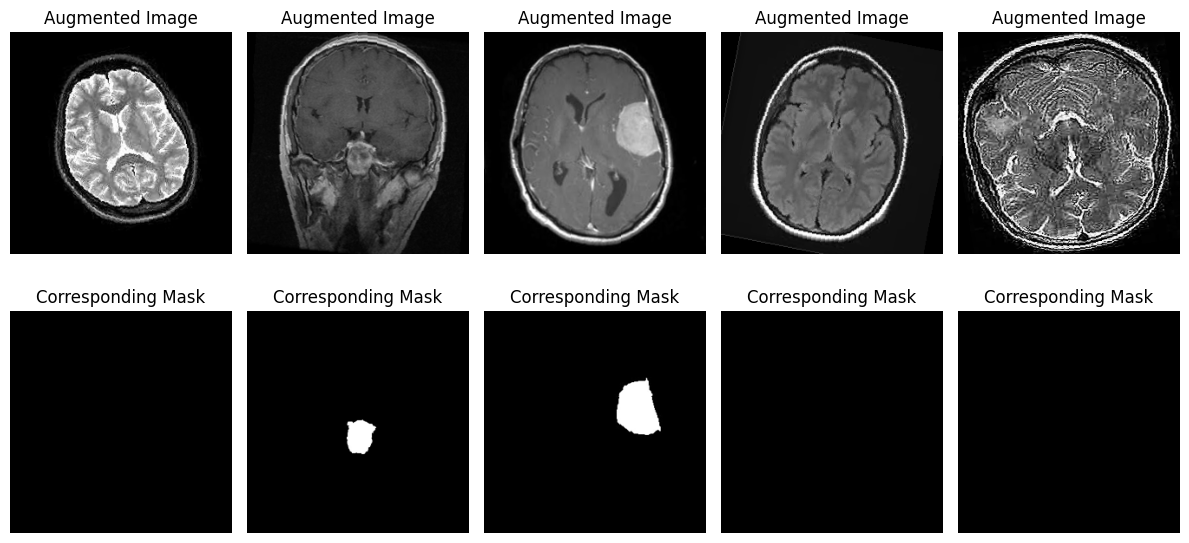

In [11]:
# Get one batch from the training loader
images, masks = next(iter(train_loader))

# Number of images to show
num_samples = 5

# Plot
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    # Image
    plt.subplot(2, num_samples, i + 1)
    img = images[i].permute(1, 2, 0).numpy()  # CHW → HWC
    img = img * 0.5 + 0.5  # De-normalize
    plt.imshow(img)
    plt.title("Augmented Image")
    plt.axis("off")

    # Mask
    plt.subplot(2, num_samples, i + 1 + num_samples)
    plt.imshow(masks[i][0], cmap='gray')
    plt.title("Corresponding Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


# U-Net

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # Encoder
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        # Final output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = self.down2(self.pool1(x1))
        x3 = self.down3(self.pool2(x2))
        x4 = self.down4(self.pool3(x3))

        # Bottleneck
        x5 = self.bottleneck(self.pool4(x4))

        # Decoder
        x = self.up4(x5)
        x = self.dec4(torch.cat([x, x4], dim=1))

        x = self.up3(x)
        x = self.dec3(torch.cat([x, x3], dim=1))

        x = self.up2(x)
        x = self.dec2(torch.cat([x, x2], dim=1))

        x = self.up1(x)
        x = self.dec1(torch.cat([x, x1], dim=1))

        return self.out_conv(x)


In [13]:
model = UNet(in_channels=3, out_channels=1).to(device)

In [14]:
from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [15]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [16]:
def dice_coef(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def iou_score(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()


In [17]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, running_dice, running_iou = 0, 0, 0

    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        running_dice += dice_coef(outputs, masks).item()
        running_iou += iou_score(outputs, masks).item()

    n = len(loader)
    return running_loss / n, running_dice / n, running_iou / n

def validate(model, loader, criterion, device):
    model.eval()
    val_loss, val_dice, val_iou = 0, 0, 0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_dice += dice_coef(outputs, masks).item()
            val_iou += iou_score(outputs, masks).item()

    n = len(loader)
    return val_loss / n, val_dice / n, val_iou / n


In [18]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [19]:
import time
# Instantiate early stopping and LR scheduler
early_stopper = EarlyStopping(patience=5, delta=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

num_epochs = 50
best_val_loss = float('inf')

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    start = time.time()

    train_loss, train_dice, train_iou = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_dice, val_iou = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)  # Reduce LR on plateau

    print(f"\nEpoch {epoch+1}/{num_epochs} | Time: {time.time() - start:.2f}s")
    print(f"  Train Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_unet_model.pth")
        print("   ModelCheckpoint: Saved best model")

    # Early stopping
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("   Early stopping triggered")
        break


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/50 | Time: 269.32s
  Train Loss: 0.3493, Dice: 0.2268, IoU: 0.2260
  Val   Loss: 0.2705, Dice: 0.2040, IoU: 0.2040
   ModelCheckpoint: Saved best model

Epoch 2/50 | Time: 255.23s
  Train Loss: 0.2303, Dice: 0.3010, IoU: 0.3010
  Val   Loss: 0.2029, Dice: 0.3568, IoU: 0.3568
   ModelCheckpoint: Saved best model

Epoch 3/50 | Time: 254.05s
  Train Loss: 0.1705, Dice: 0.3634, IoU: 0.3523
  Val   Loss: 0.1433, Dice: 0.4128, IoU: 0.3823
   ModelCheckpoint: Saved best model

Epoch 4/50 | Time: 254.71s
  Train Loss: 0.1252, Dice: 0.5401, IoU: 0.4957
  Val   Loss: 0.1061, Dice: 0.7306, IoU: 0.6640
   ModelCheckpoint: Saved best model

Epoch 5/50 | Time: 255.44s
  Train Loss: 0.0935, Dice: 0.6514, IoU: 0.5980
  Val   Loss: 0.0786, Dice: 0.6576, IoU: 0.5890
   ModelCheckpoint: Saved best model

Epoch 6/50 | Time: 254.72s
  Train Loss: 0.0702, Dice: 0.7202, IoU: 0.6674
  Val   Loss: 0.0629, Dice: 0.7155, IoU: 0.6614
   ModelCheckpoint: Saved best model

Epoch 7/50 | Time: 255.10s
  Trai

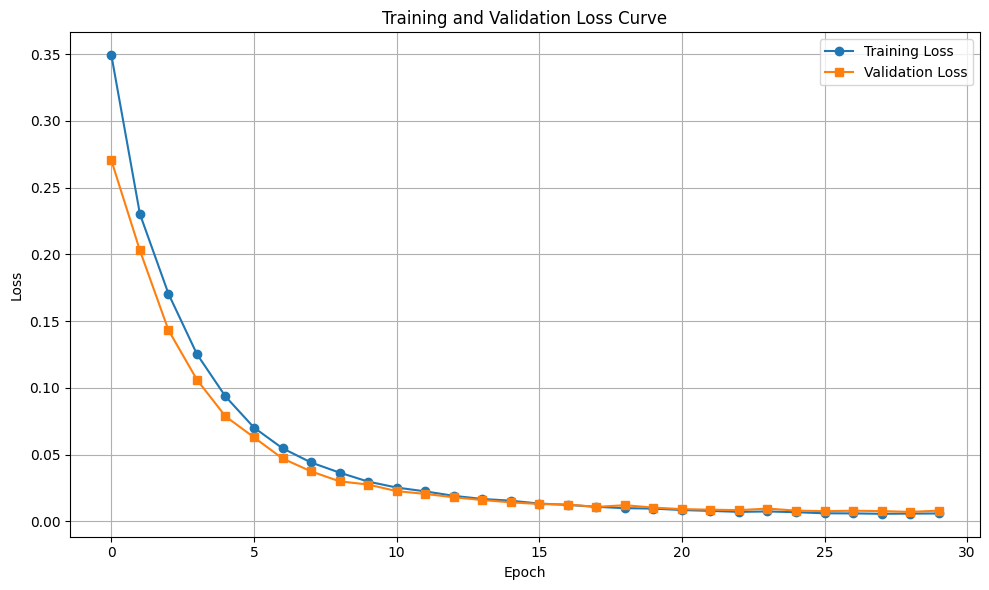

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='s')
plt.title("Training and Validation Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# Load best model weights
model.load_state_dict(torch.load("best_unet_model.pth"))
model.to(device)
model.eval()


<ipython-input-21-49e17345d31a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_unet_model.pth"))


UNet(
  (down1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=

In [22]:
def evaluate_on_test(model, test_loader, criterion, device):
    model.eval()
    test_loss, test_dice, test_iou = 0, 0, 0

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            test_loss += loss.item()
            test_dice += dice_coef(outputs, masks).item()
            test_iou += iou_score(outputs, masks).item()

    n = len(test_loader)
    return test_loss / n, test_dice / n, test_iou / n


In [23]:
test_loss, test_dice, test_iou = evaluate_on_test(model, test_loader, criterion, device)

print("\n🔍 Test Set Evaluation")
print(f"Test Loss       : {test_loss:.4f}")
print(f"Test Dice Coef  : {test_dice:.4f}")
print(f"Test IoU Score  : {test_iou:.4f}")



🔍 Test Set Evaluation
Test Loss       : 0.0076
Test Dice Coef  : 0.8940
Test IoU Score  : 0.8538


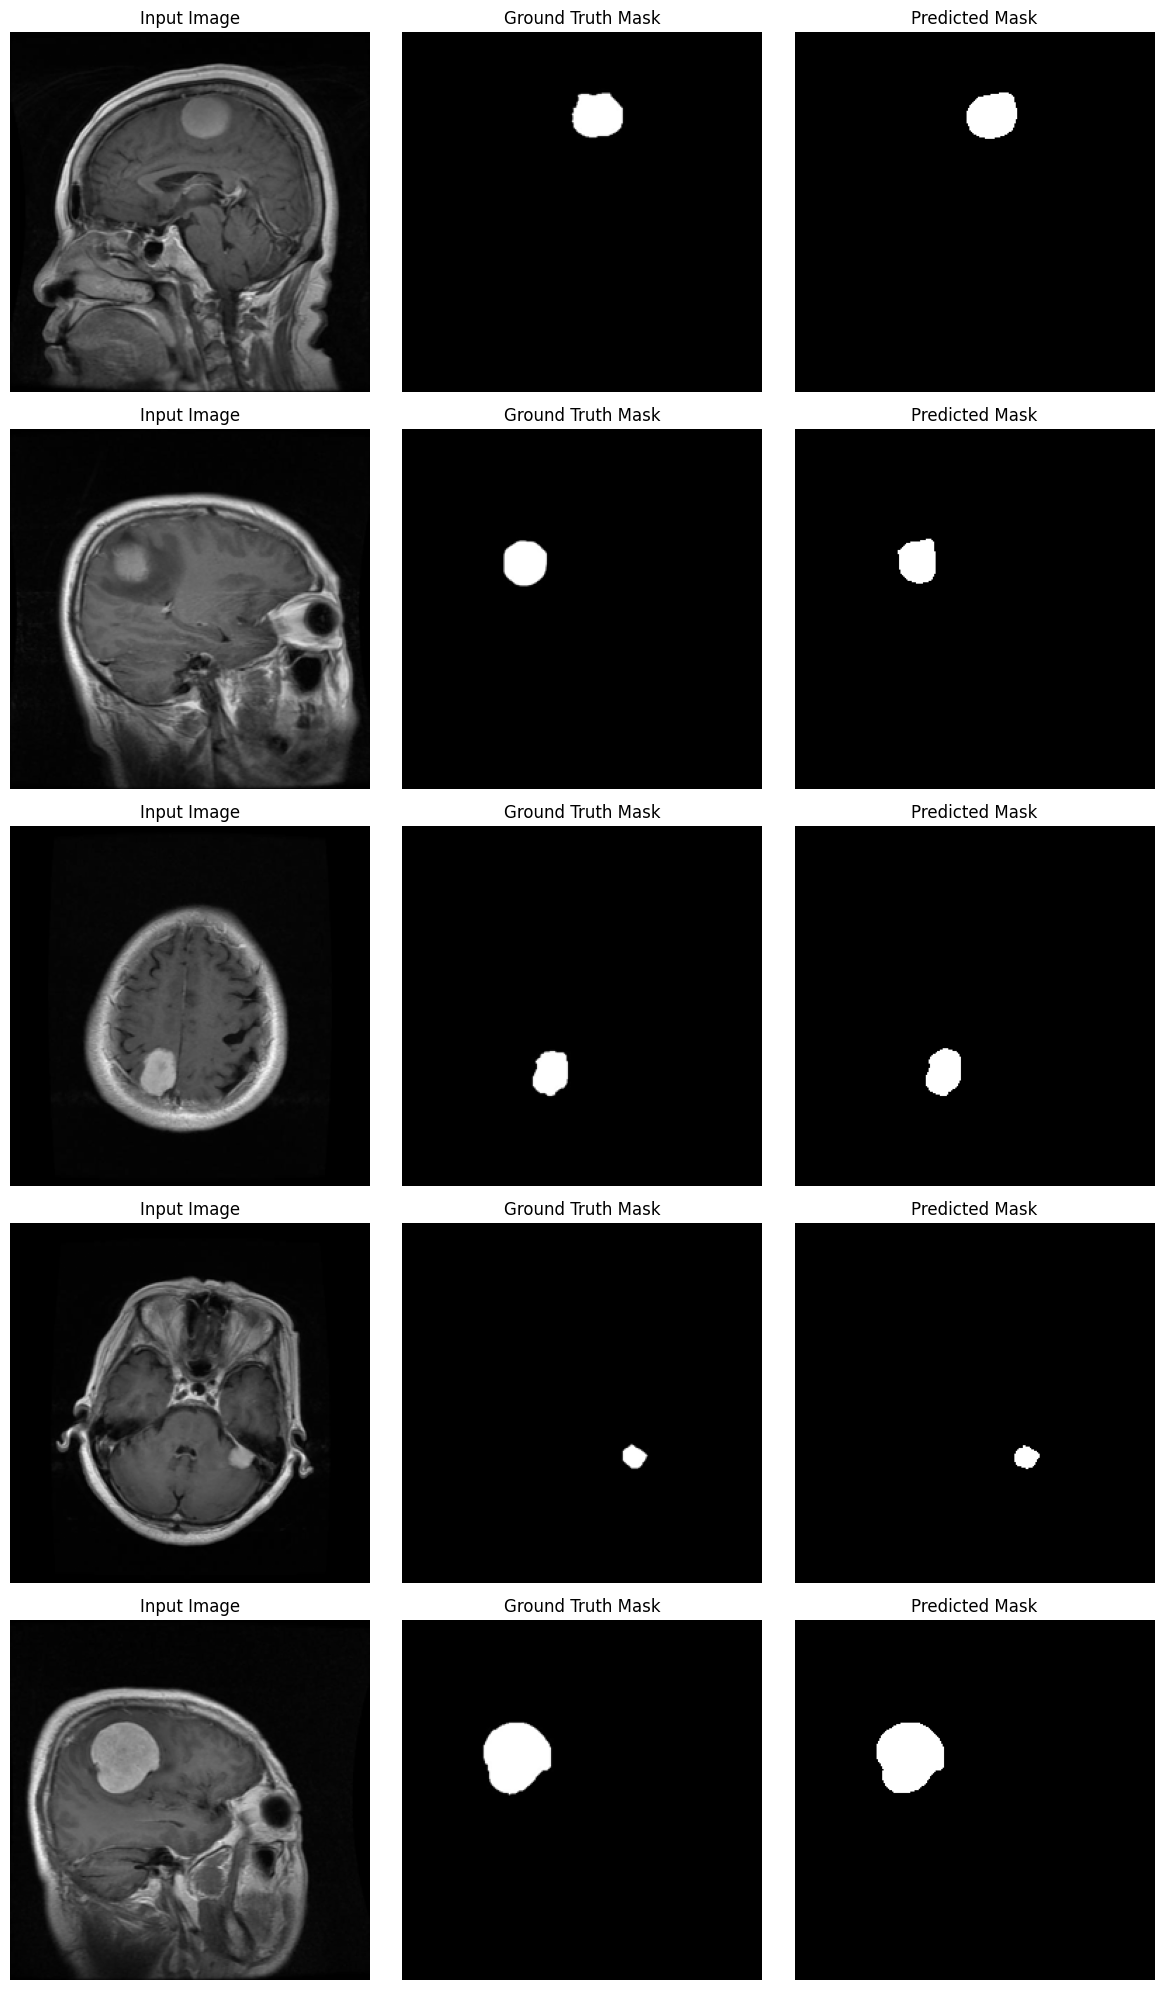

In [24]:
def visualize_predictions(model, loader, device, num_samples=5):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(12, num_samples * 4))

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            preds = (outputs > 0.5).float()

            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    break

                image_np = images[i].cpu().permute(1, 2, 0).numpy()
                mask_np = masks[i][0].cpu().numpy()
                pred_np = preds[i][0].cpu().numpy()

                # Normalize image for visualization
                image_np = (image_np * 0.5) + 0.5  # if you normalized using mean=0.5, std=0.5

                plt.subplot(num_samples, 3, images_shown * 3 + 1)
                plt.imshow(image_np)
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(num_samples, 3, images_shown * 3 + 2)
                plt.imshow(mask_np, cmap='gray')
                plt.title("Ground Truth Mask")
                plt.axis("off")

                plt.subplot(num_samples, 3, images_shown * 3 + 3)
                plt.imshow(pred_np, cmap='gray')
                plt.title("Predicted Mask")
                plt.axis("off")

                images_shown += 1

            if images_shown >= num_samples:
                break

    plt.tight_layout()
    plt.show()
visualize_predictions(model, test_loader, device, num_samples=5)

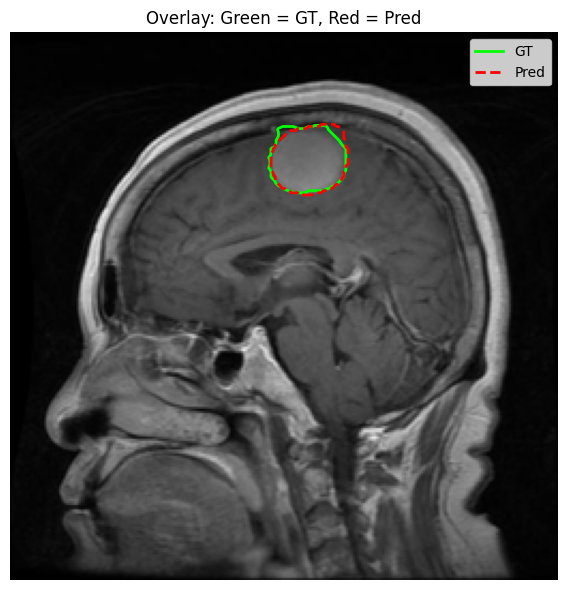

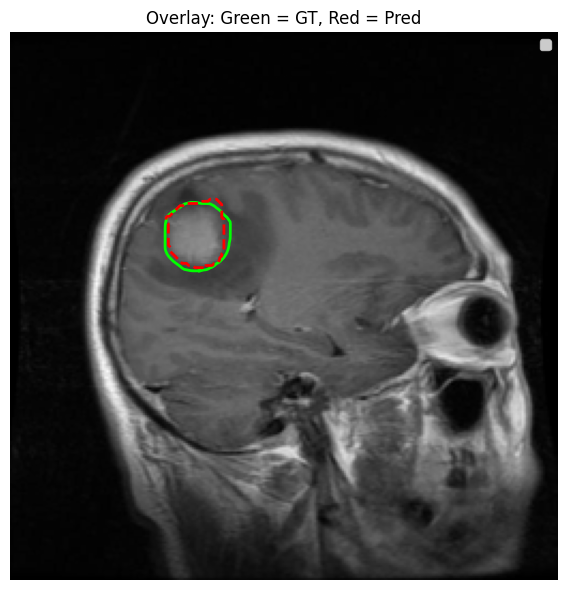

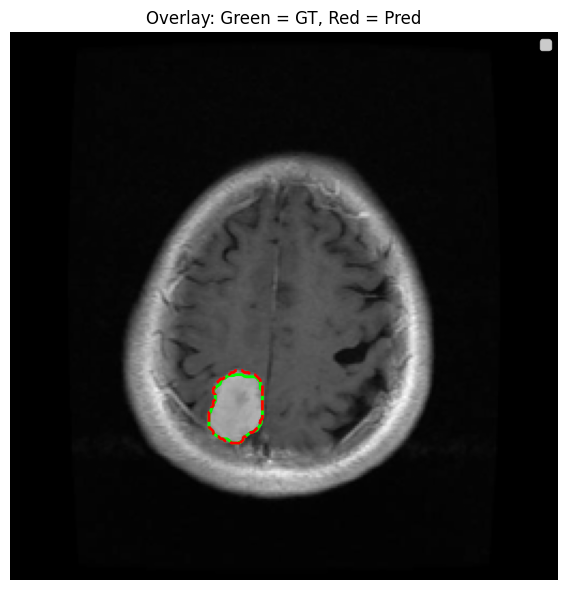

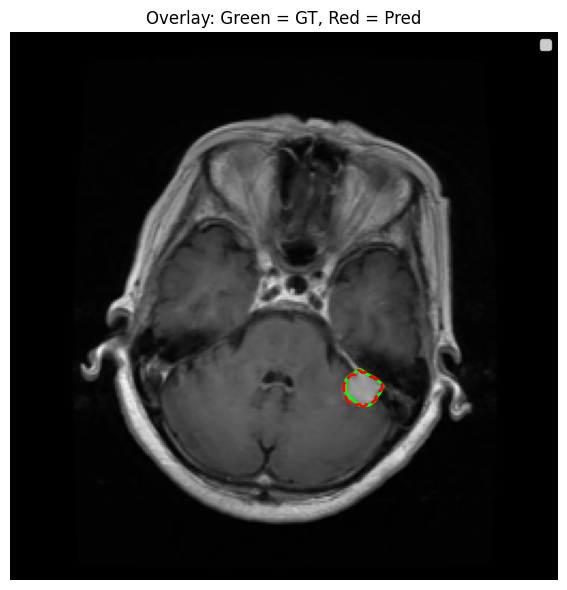

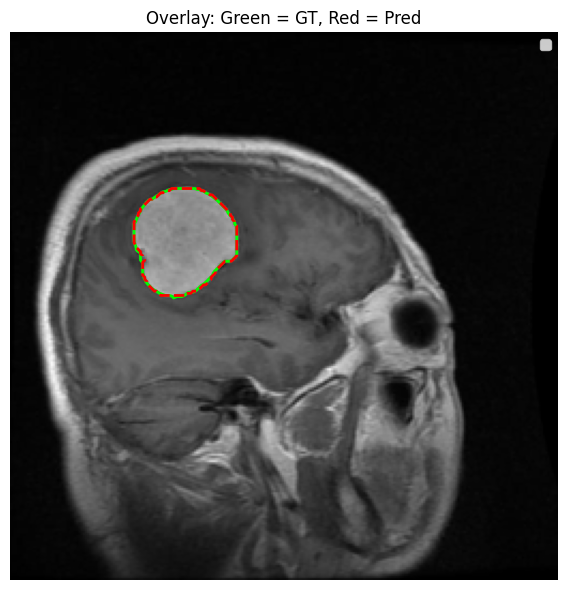

In [25]:
import matplotlib.pyplot as plt
from skimage import measure

def visualize_with_boundaries(model, loader, device, num_samples=5):
    model.eval()
    shown = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            preds = (outputs > 0.5).float()

            for i in range(images.size(0)):
                if shown >= num_samples:
                    break

                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = img * 0.5 + 0.5  # denormalize if normalized

                gt_mask = masks[i][0].cpu().numpy()
                pred_mask = preds[i][0].cpu().numpy()

                # Contour extraction
                gt_contours = measure.find_contours(gt_mask, 0.5)
                pred_contours = measure.find_contours(pred_mask, 0.5)

                plt.figure(figsize=(6, 6))
                plt.imshow(img)
                for contour in gt_contours:
                    plt.plot(contour[:, 1], contour[:, 0], color='lime', linewidth=2, label='GT' if i == 0 else "")
                for contour in pred_contours:
                    plt.plot(contour[:, 1], contour[:, 0], color='red', linestyle='--', linewidth=2, label='Pred' if i == 0 else "")
                
                plt.title("Overlay: Green = GT, Red = Pred")
                plt.axis("off")
                plt.legend(loc="upper right")
                plt.tight_layout()
                plt.show()

                shown += 1

            if shown >= num_samples:
                break
visualize_with_boundaries(model, test_loader, device, num_samples=5)


In [26]:
from PIL import Image
import torchvision.transforms.functional as TF

def predict_custom_image(model, image_path, device, target_size=(256, 256)):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = image.resize(target_size)
    
    # Transform to tensor and normalize
    image_tensor = transforms.ToTensor()(image)
    image_tensor = transforms.Normalize([0.5]*3, [0.5]*3)(image_tensor)
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension

    # Inference
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output)
        predicted_mask = (output > 0.5).float()

    # Convert tensors to numpy for visualization
    img_np = image_tensor[0].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
    mask_np = predicted_mask[0][0].cpu().numpy()

    # Plot the results
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


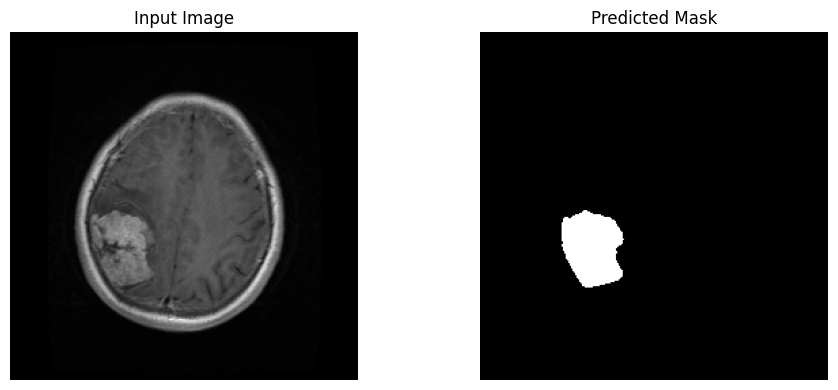

In [27]:
custom_img_path = "/kaggle/input/brain-tumor-segmentation/Brain Tumor Segmentation Dataset/image/2/Tr-me_0010.jpg"  # change to your actual image path
predict_custom_image(model, custom_img_path, device)

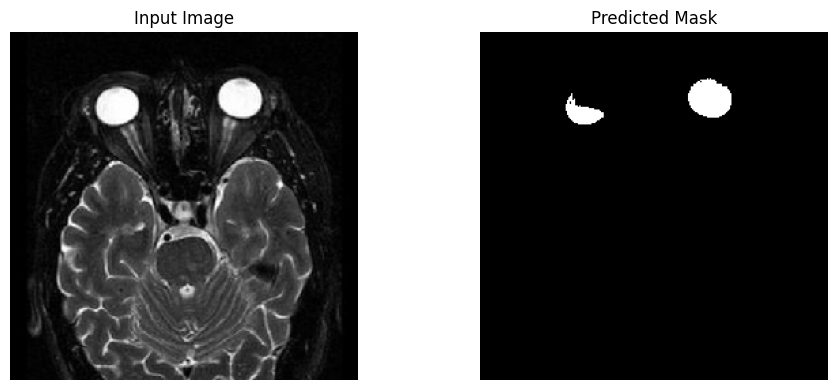

In [28]:
custom_img_path = "/kaggle/input/brain-tumor-segmentation/Brain Tumor Segmentation Dataset/image/0/Tr-noTr_0001.jpg"  # change to your actual image path
predict_custom_image(model, custom_img_path, device)

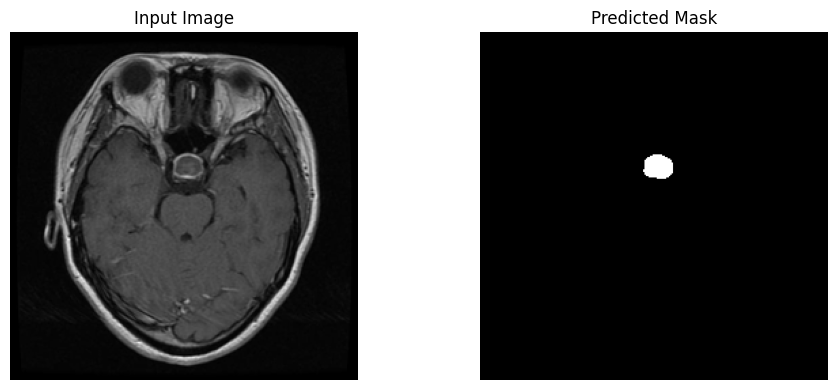

In [29]:
custom_img_path = "/kaggle/input/brain-tumor-segmentation/Brain Tumor Segmentation Dataset/image/3/Tr-piTr_0001.jpg"  # change to your actual image path
predict_custom_image(model, custom_img_path, device)

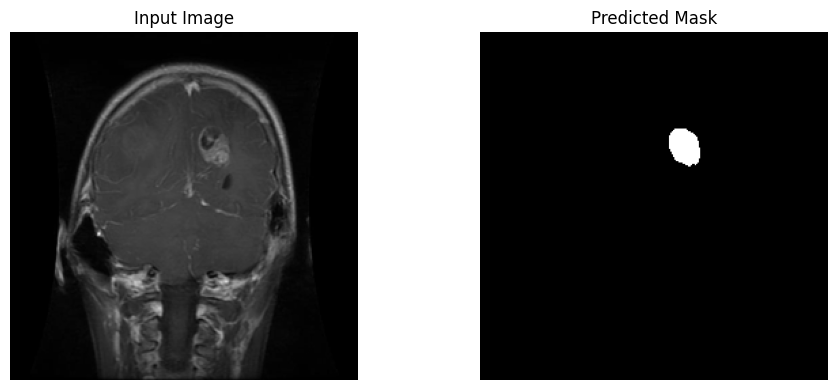

In [30]:
custom_img_path = "/kaggle/input/brain-tumor-segmentation/Brain Tumor Segmentation Dataset/image/1/Tr-gl_0031.jpg"  # change to your actual image path
predict_custom_image(model, custom_img_path, device)